In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import TransportMaps as TM
import TransportMaps.Maps as MAPS
import TransportMaps.Distributions as DIST
%matplotlib inline
mpl.rcParams['font.size'] = 15

/home/dabi/VC-Projects/Software/Mine/Current/transportmaps-private/TransportMaps/External.py:35: UserWarning: MPI support disabled: install mpi4py and mpi_map if needed.
  warnings.warn("MPI support disabled: install mpi4py and mpi_map if needed.")
/home/dabi/VC-Projects/Software/Mine/Current/transportmaps-private/TransportMaps/External.py:54: UserWarning: H5 file support disabled: install h5py if needed.
  warnings.warn("H5 file support disabled: install h5py if needed.")
/home/dabi/VC-Projects/Software/Mine/Current/transportmaps-private/TransportMaps/External.py:63: UserWarning: pyhmc is not supported: install pyhmc if needed.
  warnings.warn("pyhmc is not supported: install pyhmc if needed.")


**Biochemical oxigen demand (BOD)**

![][bodfig]

[bodfig]: Figures/BOD/PatchWork.png "By Nick Allen - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=47368571 \\ By SuSanA Secretariat - https://www.flickr.com/photos/gtzecosan/5547295000/, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=36528851 \\ By SuSanA Secretariat - https://www.flickr.com/photos/gtzecosan/3231600029/, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=36544971 \\ By SuSanA Secretariat - https://www.flickr.com/photos/gtzecosan/3232393634/, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=36545279"

The following example treat a model for the demand of dissolved oxigen by aerobic biological organism in order to break down organic material in a given water sample. The measurement of this oxigen demand helps to gauge the effectiveness of wastewater treatment plants. See [wiki](https://en.wikipedia.org/wiki/Biochemical_oxygen_demand) for more informations.

# Diagnostics and unbiased sampling

We consider here a Bayesian approach for the inference of the coefficients $A$ and $B$ of the biochemical oxigen demand (BOD) model [[OR5]](aa-references.html#sullivan2010):

$$ \mathfrak{B}(t) = A ( 1 - \exp(-Bt)) + \varepsilon \;, \quad \varepsilon \sim \mathcal{N}(0,\sigma^2) \;, $$

given a number $n$ of observations $D := [\mathfrak{B}(1), \ldots, \mathfrak{B}(n)]$.
The model parameters are endowed with the following priors

$$ A \sim \mathcal{U}(0.4, 1.2) \qquad \text{and} \qquad B \sim \mathcal{U}(0.01, 0.31) \;. $$

We consider here the approach introduced in [[TM3]](aa-references.html#parno2014) which is based on the efficient conditioning of the joint density $(\mathfrak{B}(1), \ldots, \mathfrak{B}(n), A, B) \sim \pi$.

We restrict our attention on the approximation of $(\mathfrak{B}(1), \ldots, \mathfrak{B}(n), A, B) \sim\pi$ and will consider the case $n=2$ and $\sigma^2 = 10^{-3}$.

In [2]:
import scipy.special

class BODjoint(DIST.Distribution):
    def __init__(self, numY, sigma2 = 1e-3 ):
        sigma = np.sqrt(sigma2)
        timeY=np.arange(numY)+1.
        dimDensity = numY+2
        super(BODjoint,self).__init__(dimDensity)
        self.numY = numY
        self.timeY  = timeY
        self.sigma = sigma
    def pdf(self, x, params=None, *args, **kwargs):
        return np.exp(self.log_pdf(x, params))
    def log_pdf(self, x, params=None, *args, **kwargs):
        # x is a 2-d array of points. The first dimension corresponds to the number of points.
        #The first numY columns of x refer to the data
        numY = self.numY
        Y = x[:,0:numY]
        theta1=x[:,numY] #The last two components refer to the parameters
        theta2=x[:,numY+1]
        a = .4  + .4*( 1 + scipy.special.erf( theta1/np.sqrt(2) )  )
        b = .01 + .15*( 1 + scipy.special.erf( theta2/np.sqrt(2) )  )
        return -1.0/(2*self.sigma**2) * \
            np.sum( (Y - a[:,np.newaxis]*( 1 - np.exp( -np.outer(b, self.timeY) ) ) )**2 , axis=1) + \
            -.5*( theta1**2 + theta2**2 )
    def grad_x_log_pdf(self, x, params=None, *args, **kwargs):
        numY = self.numY
        Y = x[:,0:numY]
        theta1=x[:,numY] #The last two components refer to the parameters
        theta2=x[:,numY+1]
        a = .4  + .4*( 1 + scipy.special.erf( theta1/np.sqrt(2) )  )
        b = .01 + .15*( 1 + scipy.special.erf( theta2/np.sqrt(2) )  )
        da_theta1 = .4*np.sqrt(2/np.pi)*np.exp( -theta1**2/2.)
        db_theta2 = .15*np.sqrt(2/np.pi)*np.exp( -theta2**2/2.)
        grad = np.zeros( x.shape )
        for jj in np.arange(numY):
            grad[:,numY] -= -da_theta1/(self.sigma**2)*( 1 - np.exp( - b*self.timeY[jj])  )*( Y[:,jj] - a*(1- np.exp(-b*self.timeY[jj])) )
            grad[:,numY+1] -= -1.0/(self.sigma**2)*self.timeY[jj]*db_theta2*a*np.exp(-b*self.timeY[jj])*( Y[:,jj] - a*(1- np.exp(-b*self.timeY[jj])) )
            grad[:,jj] = -1.0/self.sigma**2 *( Y[:,jj] - a*(1-np.exp(-b*self.timeY[jj])) )
        grad[:,-2] -=  theta1
        grad[:,-1] -=  theta2
        return grad
    def hess_x_log_pdf(self, x, params=None, *args, **kwargs):
        numY = self.numY
        Y = x[:,0:numY]
        theta1=x[:,numY] #The last two components refer to the parameters
        theta2=x[:,numY+1]
        a = .4  + .4*( 1 + scipy.special.erf( theta1/np.sqrt(2) )  )
        b = .01 + .15*( 1 + scipy.special.erf( theta2/np.sqrt(2) )  )
        da_theta1 = .4*np.sqrt(2/np.pi)*np.exp( -theta1**2/2.)
        db_theta2 = .15*np.sqrt(2/np.pi)*np.exp( -theta2**2/2.)
        d2a_theta1 = -theta1*da_theta1
        d2b_theta2 = -theta2*db_theta2
        Hess_x = np.zeros( (x.shape[0], x.shape[1],  x.shape[1]) )
        for jj in np.arange(numY):
            Hess_x[:,numY,numY]-= -(1-np.exp(-b*self.timeY[jj]))/(self.sigma**2)*( d2a_theta1*( Y[:,jj] - a*(1- np.exp(-b*self.timeY[jj])) ) - da_theta1**2*(1-np.exp(-b*self.timeY[jj]))  )
            Hess_x[:,numY+1,numY]-=  -da_theta1/(self.sigma**2)*( db_theta2*self.timeY[jj]*np.exp(-b*self.timeY[jj])*(Y[:,jj]-a+a*np.exp(-b*self.timeY[jj])) + (1-np.exp(-b*self.timeY[jj]))*(-a*self.timeY[jj]*db_theta2*np.exp(-b*self.timeY[jj])))
            Hess_x[:,numY+1,numY+1]-= -self.timeY[jj]*a/(self.sigma**2)*np.exp(-b*self.timeY[jj])*( ( Y[:,jj] - a*(1- np.exp(-b*self.timeY[jj])) )*( d2b_theta2 - self.timeY[jj]*db_theta2**2 ) - db_theta2**2 *self.timeY[jj]*a*np.exp(-b*self.timeY[jj]))
            Hess_x[:,numY,jj] = da_theta1/(self.sigma**2)*(1-np.exp(-b*self.timeY[jj]))
            Hess_x[:,numY+1,jj] = 1/(self.sigma**2)*self.timeY[jj]*db_theta2*a*np.exp(-b*self.timeY[jj])
            Hess_x[:,jj, numY] = Hess_x[:,numY,jj]
            Hess_x[:,jj, numY+1] = Hess_x[:,numY+1, jj]
        Hess_x[:,numY, numY+1] = Hess_x[:,numY+1, numY]
        Hess_x[:,numY,numY]-=1
        Hess_x[:,numY+1,numY+1]-=1
        for kk in np.arange(x.shape[0]):
            for jj in np.arange(numY):
                Hess_x[ kk , jj, jj]  = -1/(self.sigma**2)
        return Hess_x

In [3]:
pi = BODjoint(2, 1e-3)

We can visualize some aligned slices of this $4$-dimensional distribution:

In [4]:
fig = plt.figure(figsize=(6,6))
varstr=[r"$\mathfrak{B}(1)$", r"$\mathfrak{B}(2)$", r"$A$", r"$B$"]

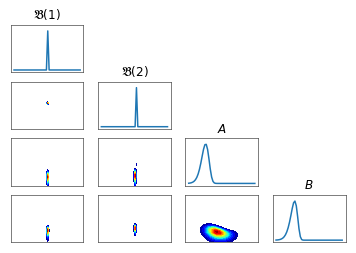

In [5]:
import TransportMaps.Diagnostics as DIAG
fig = DIAG.plotAlignedConditionals(pi, range_vec=[-4,4],
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr)

## Integrated squared parametrization

We set up and solve the following variational problem

$$
\hat{T} = \arg\min_{T \in \mathcal{T}_\triangle} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert \nu_\pi \right) \;,
$$

where $\mathcal{T}_\triangle$ is in this case the set of [integrated squared lower triangular maps](example-gumbel-1d.html#Integrated-squared-parametrization). As an initial approximation we use total order expansions with maximum order $2$ ...

In [6]:
dim = pi.dim
qtype = 3          # Gauss quadrature
qparams = [5]*dim  # Quadrature order
reg = None         # No regularization
tol = 1e-3         # Optimization tolerance
ders = 2           # Use gradient and Hessian 

In [7]:
order = 2

T2 = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    dim, order, 'total')

rho = DIST.StandardNormalDistribution( dim )

push_T2_rho = DIST.PushForwardTransportMapDistribution(T2, rho)

log = push_T2_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg, tol=tol, ders=ders)

## Diagnostics

The **estimation of the accuracy** of an approximation in high dimension is a challenging task, in particular when one seeks approximations to densities which may be unnormalized. These is a typical setting in Bayesian inference and the transport map framework has the remarkable property of providing an asymptotically reliable estimator for such accuracy.

In the following we will present two diagnostics:  

1. the **variance diagnostic** (formal and quantitative) 
2. the **pullback conditionals** (informal and qualitative).  

Diagnostic routines are contained in the following module:

In [8]:
import TransportMaps.Diagnostics as DIAG

### Variance diagnostic

As shown in [[TM1]](aa-references.html#elmoselhy2012), as $\mathcal{D}_{\rm KL}(T_\sharp \nu_\rho \vert \nu_\pi) \rightarrow 0$ (i.e. as $T\rightarrow T^\star$), the following holds:

$$ \mathcal{D}_{\rm KL}(T_\sharp \nu_\rho \vert \nu_\pi) \approx \frac{1}{2} \mathbb{V}{\rm ar}_\rho\left[ \log \frac{\rho}{T^\sharp \pi} \right] $$

The following code computes this variance diagnostic:

In [9]:
pull_T2_pi = DIST.PullBackTransportMapDistribution(T2, pi)
qtype = 0         # Monte-Carlo quadrature
qparams = 1000000 # Number of samples
var_diag = DIAG.variance_approx_kl(
    rho, pull_T2_pi, qtype=qtype, qparams=qparams)
print("Variance diagnostic: %e" % var_diag)

Variance diagnostic: 2.915653e-01


### Pullback conditionals

Note that if the transport map $T$ is accurate, then $T_\sharp \rho \approx \pi$. Then

$$ T^\sharp \pi \approx \rho \;,$$

where $\rho$ is the density of $\mathcal{N}(0,{\bf I})$.

As a consequence, $T^\sharp \pi$ needs to resemble a Standard Normal distribution, and thus all the n-dimensional conditionals (anchored to $0$) will resemble Standard Normals. We use this observation to derive the following qualitative diagnostic, where we plot all the 2-dimensional conditionals of $T^\sharp \pi$.

In [10]:
fig = plt.figure(figsize=(6,6))
varstr = [r"$\mathfrak{B}(1)$", r"$\mathfrak{B}(2)$", r"$A$", r"$B$"]

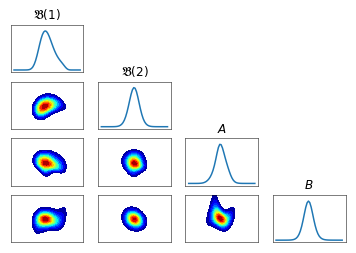

In [11]:
pull_T2_pi = DIST.PullBackTransportMapDistribution(T2, pi)
fig = DIAG.plotAlignedConditionals( pull_T2_pi, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr)

## Improving the approximation

As we could see, the obtained approximation performs pretty poorly. Let us try then to improve it using an **higher order map**, and monitor the improvement using the presented diagnostics.

In [12]:
dim = pi.dim
qtype = 3          # Gauss quadrature
qparams = [5]*dim  # Quadrature order
reg = None         # No regularization
tol = 1e-3         # Optimization tolerance
ders = 2           # Use gradient and Hessian 

In [13]:
order = 3

rho = DIST.StandardNormalDistribution( dim )
T3 = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    dim, order, 'total')
push_rho = DIST.PushForwardTransportMapDistribution(T3, rho)
# SOLVE
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

### Variance diagnostic

In [14]:
pull_T3_pi = DIST.PullBackTransportMapDistribution(T3, pi)
qtype = 0         # Monte-Carlo quadrature
qparams = 1000000 # Number of samples
var_diag = DIAG.variance_approx_kl(
    rho, pull_T3_pi, qtype=qtype, qparams=qparams)
print("\nVariance diagnostic: %e" % var_diag)


Variance diagnostic: 3.215476e-01


### Pullback conditionals

In [15]:
fig = plt.figure(figsize=(6,6))
varstr = [r"$\mathfrak{B}(1)$", r"$\mathfrak{B}(2)$", r"$A$", r"$B$"]

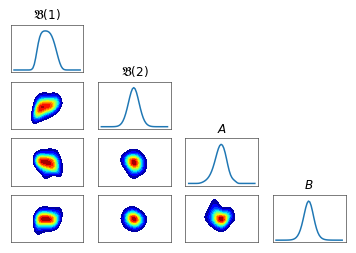

In [16]:
pull_T3_pi = DIST.PullBackTransportMapDistribution(T3, pi)
fig = DIAG.plotAlignedConditionals(pull_T3_pi, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr)

## Unbiased estimators

The approximation of a transport $\hat{T}_\sharp \nu_\rho \approx \nu_\pi$ is a key ingredient when one wants to perform the **integration** of a function $f$ over an intractable distribution $\nu_\pi$:

$$ \int f({\bf x}) \nu_\pi(d{\bf x}) \approx \int f({\bf x}) \hat{T}_\sharp\nu_\rho(d{\bf x}) $$

The direct sampling of $\hat{T}_\sharp \nu_\rho$ will introduce some **bias** in associated estimators due to the residual error. Since $\hat{T}^\sharp \nu_\pi \approx \nu_\rho$

1. we can use $\nu_\rho$ as an effective **biasing (proposal) distribution** for $\hat{T}^\sharp \nu_\pi$
2. obtain samples ${\bf X} \sim \hat{T}^\sharp \nu_\pi$
2. compute the unbiased samples $\hat{T}({\bf X})$ from $\nu_\pi$.

Unbiased sampling routines are contained in the following module:

In [17]:
import TransportMaps.Samplers as SAMP

### Importance sampling

The importance sampling [[OR6]](aa-references.html#robert2004) estimator is given by

$$ \int f({\bf x}) \pi({\bf x}) d{\bf x} = \int f({\bf x}) \frac{\pi({\bf x})}{T_\sharp \rho({\bf x})} T_\sharp \rho({\bf x}) d{\bf x} = \int f(T({\bf x})) \frac{T^\sharp\pi({\bf x})}{\rho({\bf x})} \rho({\bf x}) d{\bf x} \;. $$

One can use the **sample** $\{{\bf x}_i\}_{i=0}^N \stackrel{\rm iid}{\sim} \rho$ and **weights** $w_i = \left. T^\sharp\pi({\bf x}_i) \middle/ \rho({\bf x}_i) \right.$ to obtain the Monte-Carlo approximation

$$ \int f({\bf x}) \pi({\bf x}) d{\bf x} \approx \sum f({\bf x}_i) \bar{w}_i \;, $$

where $\bar{w}_i = \left. w_i \middle/ \sum w_i \right. $.

* If $\pi \approx c T_\sharp \rho$ then the weights will have **little variance**
* If $\pi \neq c T_\sharp \rho$ the weights will have a **high variance**, providing poor estimators.

The form

$$
\int f(T({\bf x})) \frac{T^\sharp\pi({\bf x})}{\rho({\bf x})} \rho({\bf x}) d{\bf x}
$$

is preferred to 

$$
\int f({\bf x}) \frac{\pi({\bf x})}{T_\sharp \rho({\bf x})} T_\sharp \rho({\bf x}) d{\bf x}
$$

in this case because it does not involves the evaluation of the density $T_\sharp \rho({\bf x})$ which requires the sequential inversion (root finding) of the components of $T$ (this is the case for direct transports, see [inverse transports](examples-transport-from-samples.html)).

We generate $N=10^4$ importance samples and weights for $\pi$ using the two approximation of the maps obtained. 

The quality of such samples is evaluated looking at the variance of the weights $\mathbb{V}{\rm ar}[w_i]$, which by definition is strictly related to the [variance diagnostic](example-BOD-4d.html#variance-diagnostic).

In [18]:
N = 10000
# Approximation T2
pull_T2_pi = DIST.PullBackTransportMapDistribution(T2, pi)
sampler_T2 = SAMP.ImportanceSampler(pull_T2_pi, rho)
(xt2, wt2) = sampler_T2.rvs(N)
yt2 = T2.evaluate(xt2) # Importance samples from \pi
var_T2 = np.var(wt2) * N
print("Variance weights (T2): %e" % var_T2)
# Approximation T3
pull_T3_pi = DIST.PullBackTransportMapDistribution(T3, pi)
sampler_T3 = SAMP.ImportanceSampler(pull_T3_pi, rho)
(xt3, wt3) = sampler_T3.rvs(N)
yt3 = T3.evaluate(xt3) # Importance samples from \pi
var_T3 = np.var(wt3) * N
print("Variance weights (T3): %e" % var_T3)

Variance weights (T2): 1.665032e-03
Variance weights (T3): 2.928678e-02


### Metropolis Hastings with independent proposals

A similar approach to obtain unbiased estimators is to generate a Markov chain with the target distribution $\nu_\pi$ as **invariant distribution**.

If in importance sampling we obtained an unbiased estimator at the expense of some variance in the weights, here we do it at the expense of independency (not an iid sample). Thus the quality of the sample can be assessed looking at the decay of autocorrelation of the sample.

We use a very basic MCMC sampler (Metropolis Hastings with independent proposals [[OR6]](aa-references.html#robert2004)): 

1. generate a Markov chain (MC) with 
    * invariant distribution $\hat{T}^\sharp \nu_\pi$ 
    * using proposal distribution $\nu_\rho$
2. push forward the MC through T obtaining a MC with 
    * invariant distribution $\nu_\pi$.

The following code generates a Markov Chain of $N=10000$ samples...

In [19]:
burnin = 5000
N = 20000
# Approximation T2
pull_T2_pi = DIST.PullBackTransportMapDistribution(T2, pi)
sampler_T2 = SAMP.MetropolisHastingsIndependentProposalsSampler(
    pull_T2_pi, rho)
(xt2, _) = sampler_T2.rvs(N)
xt2 = xt2[burnin:,:]
yt2 = T2.evaluate(xt2) # Markov chain from \pi
# Approximation T3
pull_T3_pi = DIST.PullBackTransportMapDistribution(T3, pi)
sampler_T3 = SAMP.MetropolisHastingsIndependentProposalsSampler(
    pull_T3_pi, rho)
(xt3, _) = sampler_T3.rvs(N)
xt2 = xt2[burnin:,:]
yt3 = T3.evaluate(xt3) # Markov chain from \pi

... let's check the quality of the chain by means of the **autocorrelation** ...

In [20]:
def plot_acorr(x, LAGS, title):
    plt.figure(figsize=(16,4))
    nsamps = x.shape[0]
    for d in range(dim):
        ax = plt.subplot(1,dim,d+1)
        s = x[:,d] - np.mean(x[:,d])
        _ = ax.acorr(s, usevlines=True, normed=True, maxlags=LAGS, lw=1)
        var = 1. / np.arange(nsamps, nsamps-LAGS-1, -1)
        cnfint = 1.96 * np.sqrt(var)
        _ = ax.plot(np.arange(LAGS+1), cnfint, '--r')
        _ = ax.plot(np.arange(LAGS+1), -cnfint, '--r')
        ax.set_xlim(0,LAGS)
        if d == 0:
            ax.set_ylabel(title)
        if d > 0:
            ax.get_yaxis().set_visible(False)

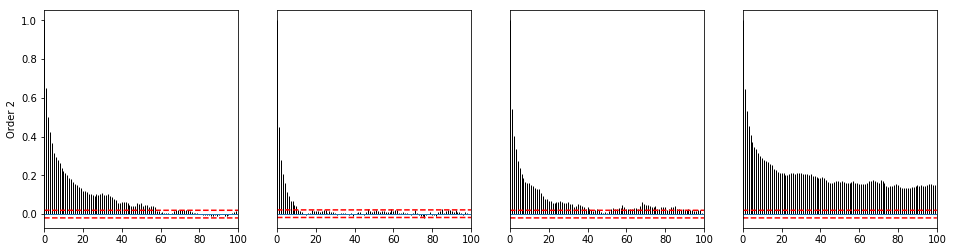

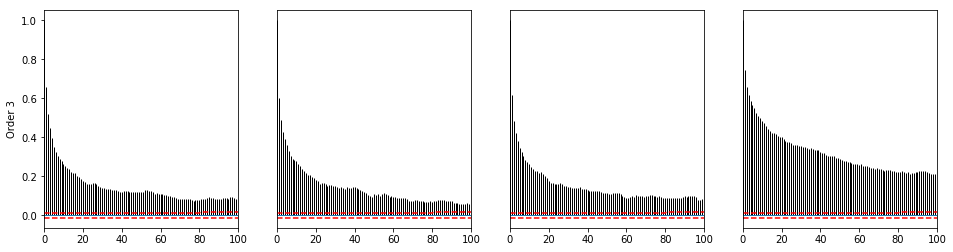

In [21]:
plot_acorr(xt2, 100, "Order 2")
plot_acorr(xt3, 100, "Order 3")

In [22]:
def plot_xcorr(x, LAGS):
    plt.figure(figsize=(6,6))
    nsamps = x.shape[0]
    for d1 in range(dim):
        for d2 in range(d1+1):
            ax = plt.subplot(dim,dim,(d1*dim)+d2+1)
            _ = ax.xcorr(x[:,d1], x[:,d2], usevlines=True, normed=True, maxlags=LAGS, lw=0.3)
            var = 1. / np.arange(nsamps, nsamps-LAGS-1, -1)
            cnfint = 1.96 * np.sqrt(var)
            _ = plt.plot(np.arange(LAGS+1), cnfint, '--r', lw=0.5)
            _ = plt.plot(np.arange(LAGS+1), -cnfint, '--r', lw=0.5)
            ax.set_xlim(0,LAGS)
            ax.set_ylim(-1, 1)
            if d2 > 0:
                ax.get_yaxis().set_visible(False)
            if d1 < dim-1:
                ax.get_xaxis().set_visible(False)

... Let's check the **crosscorrelation** between components for order 2 ...

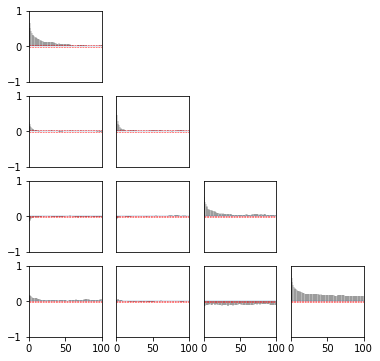

In [23]:
plot_xcorr(xt2, 100)

... Let's check the **crosscorrelation** between components for order 3 ...

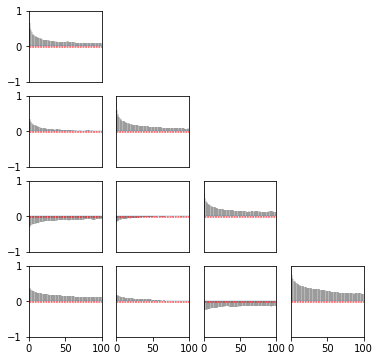

In [24]:
plot_xcorr(xt3, 100)

... finally let's check the **mixing** of the two chains ...

In [25]:
def plot_mixing(x, start, stop, title):
    plt.figure(figsize=(16,4))
    nsamps = x.shape[0]
    for d in range(dim):
        ax = plt.subplot(1,dim,d+1)
        _ = ax.plot(range(start,stop),x[start:stop,d])
        if d == 0:
            ax.set_ylabel(title)

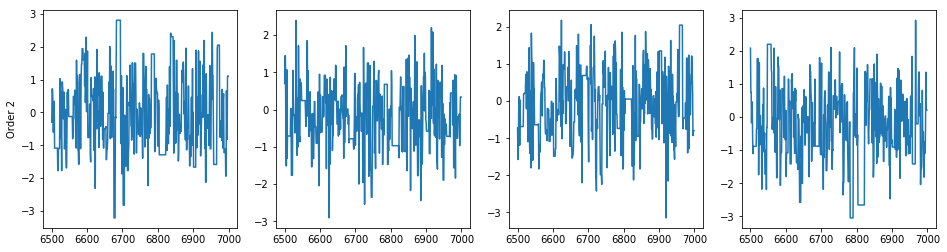

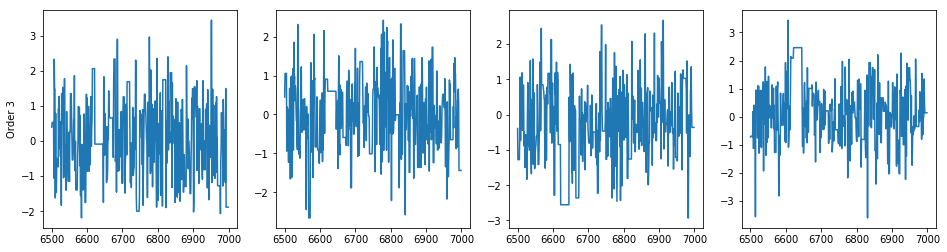

In [26]:
plot_mixing(xt2, 6500, 7000, "Order 2")
plot_mixing(xt3, 6500, 7000, "Order 3")

### Plotting marginals

In [27]:
fig = plt.figure(figsize=(6,6));

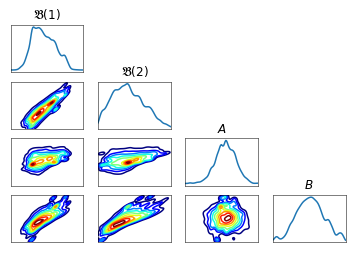

In [28]:
fig = DIAG.plotAlignedMarginals(
    yt3, vartitles=varstr, fig=fig, show_flag=False,
    figname='./Figures/BOD/BODmarginals.pdf')

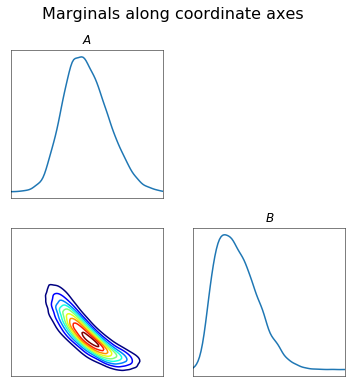

In [29]:
fig = plt.figure(figsize=(6,6));
varstr_cond = [r"$A$", r"$B$"]
ncnd_smp = 10000
smp = np.zeros((ncnd_smp,4))
smp[:,:2] = yt3[5000,:2]
rho2 = DIST.StandardNormalDistribution(2)
smp[:,2:] = rho2.rvs(ncnd_smp)
push_smp = T3.evaluate(smp)
fig = DIAG.plotAlignedMarginals(
    push_smp[:,2:],
    vartitles=varstr_cond, fig=fig, show_flag=False,
    figname='./Figures/BOD/BODcond-marginals.pdf')

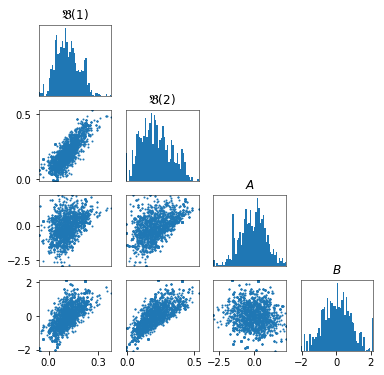

In [30]:
fig = plt.figure(figsize=(6,6));
fig = DIAG.plotAlignedScatters(
    yt3[5000:7000,:], s=1, bins=50, vartitles=varstr, 
    fig=fig, show_flag=False)